# FCC Neural Network SMS Text Classification (ML with Python Project) (RNN - NLP)

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam":
- A "ham" message is a normal message sent by a friend.
- A "spam" message is an advertisement or a message sent by a company.

You should create a function called ```predict_message``` that takes a message string as an argument and returns a list:
- The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1).
- The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/) dataset. The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

**Link:** https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/neural-network-sms-text-classifier

In [ ]:
# NOTICE:

# An online article/tutorial from towardsdatascience.com called "NLP: Spam Detection 
# in SMS (text) data using Deep Learning", written on July 27th of 2020 by
# Sudip Shrestha, PhD was carefully followed by myself (André) and its code was adapted 
# so that I could be able to implement this freeCodeCamp project.

# As the article states:
# "The purpose (...) is to understand how we can use TensorFlow2 to build 
# SMS spam detection model. Particularly, we will build a binary classification model 
# to detect whether a text message is spam or not (aka Ham). Moreover, we’ll learn 
# how to implement Dense, Long Short Term Memory (LSTM) and Bidirectional-LSTM (Bi-LSTM) 
# deep learning models in TensorFlow2 Keras API."

# Source: https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

## 1. Import Libraries

In [ ]:
# Libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#%matplotlib inline

# Library for train test split
from sklearn.model_selection import train_test_split

# Tensorflow machine learning library
try:
  # %tensorflow_version only exists in Colab.
  !pip install tensorflow
  #!pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds

# Deep learning libraries for text pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep learning libraries for modelling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0-dev20221229


## 2. Import Data

In [ ]:
# Get data files
!wget -nc https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -nc https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

# Read/Load files into dataframes
train = pd.read_table(train_file_path, names=['label', 'message'])
test = pd.read_table(test_file_path, names=['label', 'message'])

# Uniting both datasets (train and test) to be easier to analyse and manipulate the data
df = train.append(test).reset_index(drop=True)

File ‘train-data.tsv’ already there; not retrieving.

File ‘valid-data.tsv’ already there; not retrieving.



In [ ]:
# store each model evaluation for later comparison
models_evaluation = {}

## 3. Exploring The Data

In [ ]:
df.tail(3)

,label,message
5568,ham,where are you ? what are you doing ? are yuou ...
5569,spam,ur cash-balance is currently 500 pounds - to m...
5570,spam,not heard from u4 a while. call 4 rude chat pr...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5571 non-null   object
 1   message  5571 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.describe()

# Analysis:
# - We have a total of 5571 labels and SMS messages.
# - There are 2 unique labels: 'ham' or 'spam'.
# - There are less unique messages (5156) than total messages count (5571), indicating
# some repeated messages.
# - The most frequent label is 'ham', and the most frequent 'message' is 
# "sorry, i'll call later" with 30 duplicated messages.

,label,message
count,5571,5571
unique,2,5156
top,ham,"sorry, i'll call later"
freq,4824,30


In [ ]:
duplicated_rows = df[ df.duplicated() ]
print(duplicated_rows.count())

# Analysis:
# - There are 415 duplicated messages (rows with repeated label and message).

label      415
message    415
dtype: int64


In [ ]:
df.groupby('label').describe().T

# Analysis:
# - There are 4824 'ham' messages (86%) as opposed to 747 'spam' messages (13%). This
# indicates we have an imbalanced data, which needs to be fixed.
# - The most popular 'ham' message is "sorry, i'll call later" occurring 30 times, whereas
# the most popular 'spam' message is "please call our customer service representativ..."
# occurring 4 times.

label                              ham  \
message count                     4824   
        unique                    4514   
        top     sorry, i'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                642  
        top     please call our customer service representativ...  
        freq                                                    4

In [ ]:
# Now, we will use WordCloud to visualize which words are most frequent in each
# class (ham and spam)

# get all the ham and spam messages
ham_msg = df[ df.label == 'ham' ]
spam_msg = df[ df.label == 'spam' ]

# convert ham and spam messages into unique strings to visualize using wordcloud
ham_msg_text = "".join(ham_msg.to_numpy().flatten().tolist())
spam_msg_text = "".join(spam_msg.to_numpy().flatten().tolist())

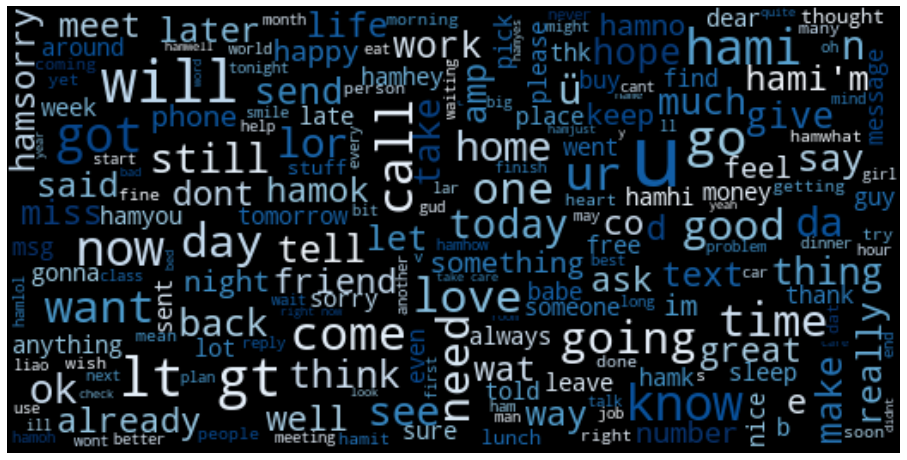

In [ ]:
# WordCloud() extracts most commonly found words in ham and spam messages,
# removing "stop words" such as 'the', 'a', 'is', etc., and plot it.

def plot_word_cloud(text):
  msg_cloud = WordCloud(
    width=520, height=260,
    stopwords=STOPWORDS,
    max_font_size=50,
    background_color='black', colormap='Blues'
    ).generate(text)
  plt.figure(figsize=(16,10))
  plt.imshow(X=msg_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

# wordcloud of ham messages
plot_word_cloud(ham_msg_text)

# Analysis:
# - The 'ham' message word cloud shows that the most commonly appeared words are:
# 'will', 'got', 'need', 'know'

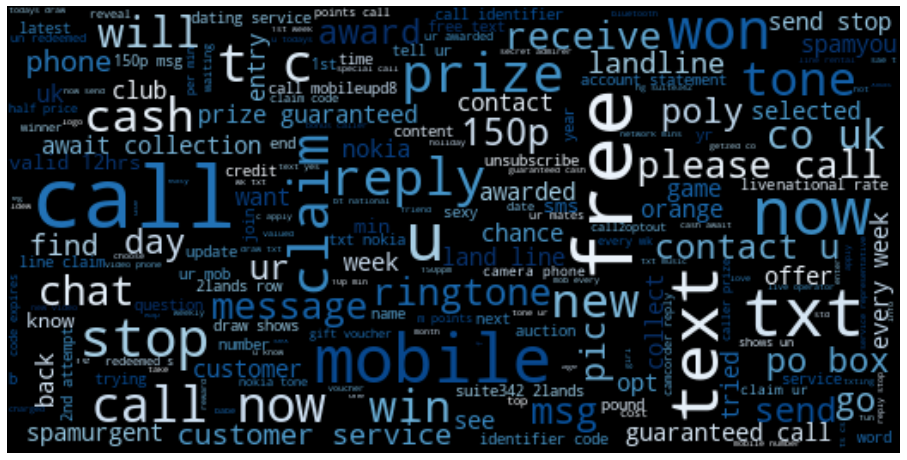

In [ ]:
# wordcloud of spam messages
plot_word_cloud(spam_msg_text)

# Analysis:
# - The 'spam' message word cloud shows that the most commonly appeared words are:
# 'free', 'call', 'mobile', 'claim', 'now', 'call', 'prize'

Messages (ham, spam) %: (86.59127625201938, 13.408723747980615)



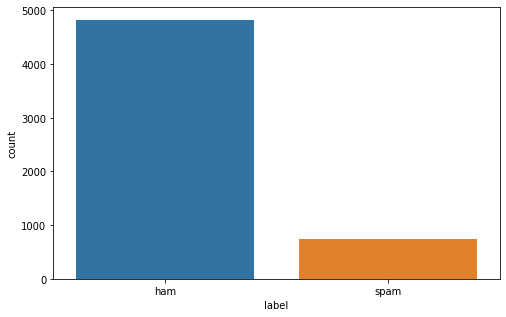

In [ ]:
# Explore the imbalanced data

def get_ham_spam_percentages(df):
  ham_count = df['label'].value_counts()['ham']
  spam_count = df['label'].value_counts()['spam']
  total = df['label'].count()
  ham_pct = (ham_count / total) * 100
  spam_pct = (spam_count / total) * 100
  return (ham_pct, spam_pct)

plt.figure(figsize=(8,5))
sns.countplot(x=df.label)
print('Messages (ham, spam) %:', get_ham_spam_percentages(df))
print()

# Analysis:
# - Only 13% of all the messages are labelled as 'spam'.
# - To handle imbalanced data we can undersample/downsample the training set.
# Downsampling is a process where you randomly delete some of the observations from
# the majority class (ham) so that the numbers in majority and minority (spam) classes are
# matched.

In [ ]:
# We fix the imbalanced data by downsampling ham messages (majority class) to
# the same number of spam messages (minority class), i.e., to 747 messages in
# each class
n_samples = len(spam_msg)
ham_msg_df = ham_msg.copy().sample(n=n_samples, random_state=44)
spam_msg_df = spam_msg.copy()
print(ham_msg_df.shape, spam_msg_df.shape)

# Note: random_state argument is for reproducibility (if integer provided);
# "None" to not have reproducibility

(747, 2) (747, 2)


Text(0.5, 0, 'Message types')

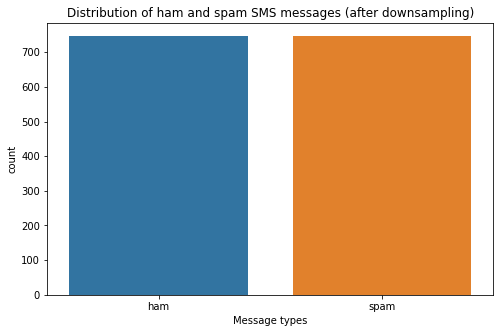

In [ ]:
# create a single dataframe with the ham and spam dataframes
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

# plot distribution of ham and spam SMS messages (after downsampling)
plt.figure(figsize=(8,5))
sns.countplot(x=msg_df.label)
plt.title('Distribution of ham and spam SMS messages (after downsampling)')
plt.xlabel('Message types')

In [ ]:
# get length column for each text entry
msg_df['text_length'] = msg_df['message'].apply(len)

# calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

# Analysis:
# - On average:
# -- the 'ham' message has a length of 70 words;
# -- the 'spam' message has a length of 138 words.
# Note: This length info shall be useful later when setting "maxlen" parameter.

,text_length
label,
ham,70.653280
spam,138.601071


## 4. Data Preprocessing

In [ ]:
# Convert text label to numeric
# (Map 'ham' label as 0 and 'spam' as 1)
msg_df['msg_type'] = msg_df['label'].map({ 'ham': 0, 'spam': 1 })

# Convert label to numpy arrays to fit deep learning models
msg_label = msg_df['msg_type'].values # numpy array

# Split data into training set (80%) and testing set (20%)
train_features, test_features, train_labels, test_labels = train_test_split(
    msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [ ]:
# Use text pre-processing: Tokenization, Sequencing and Padding:
# - Tokenizatin - split sentences into words and encode these into integers
# - Sequencing - represent each sentence by sequences of numbers.
# - Padding - pad each sequence for all sequences of numbers to have the same length.

In [ ]:
# Tokenization

# Pre-processing hyper-parameters
max_len = 50 # maximum number of words per sentence (SMS message)
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>" # replaces out-of-vocabulary words (words that are not in our corpus)
# during text_to_sequence calls
vocab_size = 500 # how many unique words to load in training and testing data

# Tokenize the words
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(train_features)
## If char_level=False, then every word will be treated as a token.
## If char_level=True, then every character will be treated as a token.

# Get total words from word index
word_index = tokenizer.word_index
#print(word_index)
#{'<OOV>': 1, 'to': 2, 'you': 3, 'a': 4, 'i': 5, ...}

# Check how many words are indexed
total_words = len(word_index)
print('There are {words} unique tokens in training data.'.format(words=total_words))

There are 4136 unique tokens in training data.


In [ ]:
# Sequencing and Padding training and testing features:
# - Sequencing - represent each sentence by sequences of numbers.
# - Padding - pad each sequence for all sequences of numbers to have the same length.

def sequence_and_pad_text_features(features):
  sequences = tokenizer.texts_to_sequences(features)
  padded = pad_sequences(
    sequences, maxlen=max_len,
    padding=padding_type, truncating=trunc_type)
  return padded

training_padded = sequence_and_pad_text_features(train_features)
testing_padded = sequence_and_pad_text_features(test_features)
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

# Analysis:
# - There are 1195 training sequences (sentences), each with 50 tokens (words)
# - There are 299 testing sequences (sentences), each with 50 tokens (words)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [ ]:
# Padded sequence of the first sentence
print('Padded sequence of the first sentence:')
print(training_padded[0])
print('Padded sequence length:', len(training_padded[0]))

# Sequence of the first sentence
first_sentence_sequence = [[v] for v in training_padded[0] if v != 0]
first_sentence = tokenizer.sequences_to_texts( first_sentence_sequence )
print('\nSequence of the first sentence:')
print(first_sentence_sequence)
print('Sequence length:', len(first_sentence_sequence))

# First sentence
print('\nFirst sentence:')
print(first_sentence)

# Analysis:
# - As mentioned, there are 50 tokens in the first sequence.

Padded sequence of the first sentence:
[ 64  31  87   3 392  13  38   8  15 131  74   1   4   1  62   1   1  10
   8   1   7  19   1   1   1 149   1   1  64 220 139   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Padded sequence length: 50

Sequence of the first sentence:
[[64], [31], [87], [3], [392], [13], [38], [8], [15], [131], [74], [1], [4], [1], [62], [1], [1], [10], [8], [1], [7], [19], [1], [1], [1], [149], [1], [1], [64], [220], [139]]
Sequence length: 31

First sentence:
['t', 'mobile', 'customer', 'you', 'may', 'now', 'claim', 'your', 'free', 'camera', 'phone', '<OOV>', 'a', '<OOV>', 'go', '<OOV>', '<OOV>', 'for', 'your', '<OOV>', 'call', 'on', '<OOV>', '<OOV>', '<OOV>', 'offer', '<OOV>', '<OOV>', 't', "c's", 'apply']


## 5. Modelling

#### Dense Spam Detection Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

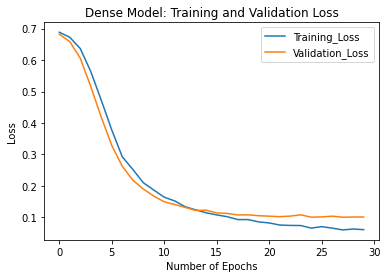

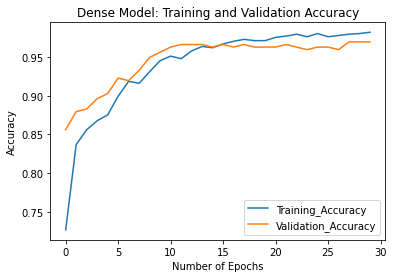

In [ ]:
# Dense Spam Detection Model

# Define model hyper-parameters
vocab_size = 500 # as defined earlier
embedding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

# Define a Dense model architecture
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(), # use this layer instead of GlobalAveragePooling1D
    Dense(24, activation='relu'),
    Dropout(drop_value),
    Dense(1, activation='sigmoid')
])

model1.summary()

# Compiling the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting hyper-parameters:
num_epochs = 30 
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Training (fitting) the model
history = model1.fit(
    x=training_padded, y=train_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, test_labels),
    callbacks=[early_stop],
    verbose=2)

# Evaluating the model
models_evaluation['rnn_dense'] = model1.evaluate(x=testing_padded, y=test_labels)
[val_loss, val_accuracy] = models_evaluation['rnn_dense']
print("\nValidation output: loss: {} - accuracy: {}".format(val_loss, val_accuracy))

# Visualize history results by plotting loss and accuracy by number of epochs
metrics = pd.DataFrame(history.history)

def rename_metrics_columns(metrics):
  metrics.rename(columns={
    'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
    'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'},
    inplace=True)
rename_metrics_columns(metrics)

def plot_graphs(var1, var2, string, metrics, model_title):
  metrics[[var1, var2]].plot()
  plt.title(f'{model_title}: Training and Validation ' + string)
  plt.xlabel('Number of Epochs')
  plt.ylabel(string)
  plt.legend([var1, var2])
  plt.show()

plot_graphs('Training_Loss', 'Validation_Loss', 'Loss', metrics, 'Dense Model')
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'Accuracy', metrics, 'Dense Model')

#### LSTM Spam Detection Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 lstm_1 (LSTM)               (None, 50, 20)            3280      
                                                                 
 dense_2 (Dense)             (None, 50, 1)             21        
                                                                 
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
38/38 - 14s - loss: 0.6799 - accuracy: 0.6076 - val_loss: 0.6027 - val_accuracy: 0.6756 - 14s/epoch - 375ms/step
Epoch 2/30
38/38 - 2s - loss: 0.4134 - accuracy: 0.8284 - 

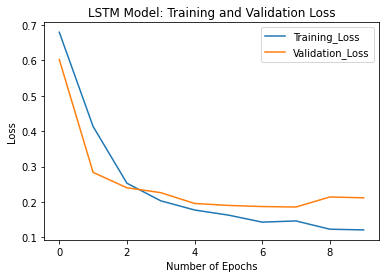

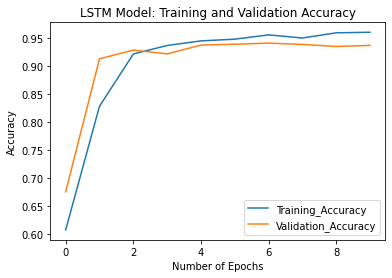

In [ ]:
# LSTM Spam Detection Model (Long Short Term Memory)

# Define model hyper-parameters
n_lstm = 20 # number of nodes in the hidden layers within the LSTM cell
drop_lstm = 0.2 # drops learnable parameters between layers, which helps avoid overfitting

# Define a LSTM model architecture
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(n_lstm, dropout=drop_lstm, return_sequences=True),
    LSTM(n_lstm, dropout=drop_lstm, return_sequences=True),
    Dense(1, activation='sigmoid')
])

model2.summary()

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting hyper-parameters (same as Dense model, except applying reshape() function on labels)
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Training (fitting) the model
history = model2.fit(
    x=training_padded, y=train_labels.reshape(-1,1),
    epochs=num_epochs, validation_data=(testing_padded, test_labels.reshape(-1,1)),
    callbacks=[early_stop],
    verbose=2)

# Evaluating the model
models_evaluation['rnn_lstm'] = model2.evaluate(x=testing_padded, y=test_labels.reshape(-1,1))
[val_loss, val_accuracy] = models_evaluation['rnn_lstm']
print("\nValidation output: loss: {} - accuracy: {}".format(val_loss, val_accuracy))

# Visualize history results by plotting loss and accuracy by number of epochs
metrics = pd.DataFrame(history.history)
rename_metrics_columns(metrics)
plot_graphs('Training_Loss', 'Validation_Loss', 'Loss', metrics, 'LSTM Model')
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'Accuracy', metrics, 'LSTM Model')

#### Bi-LSTM Spam Detection Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 50, 1)             41        
                                                                 
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
38/38 - 8s - loss: 0.6799 - accuracy: 0.6049 - val_loss: 0.6365 - val_accuracy: 0.6675 - 8s/epoch - 208ms/step
Epoch 2/30
38/38 - 1s - loss: 0.4664 - accuracy: 0.8044 - val_loss: 0.2750 - val_accuracy: 0.9304 - 1s/epoch - 37ms/step
Epoch

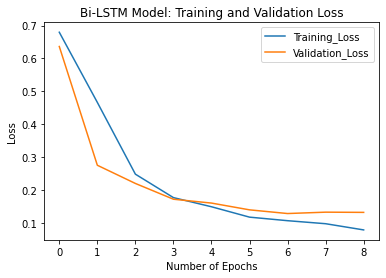

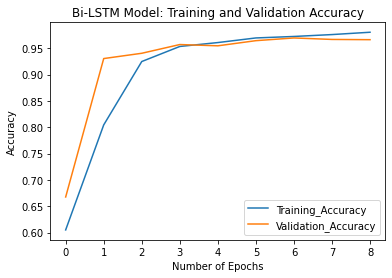

In [ ]:
# Bi-LSTM Spam Detection Model (Bidirectional Long Short Term Memory)

# Define model hyper-parameters (same as LSTM model)
n_lstm = 20 # number of nodes in the hidden layers within the LSTM cell
drop_lstm = 0.2 # drops learnable parameters between layers, which helps avoid overfitting

# Define a Bi-LSTM model architecture
model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)),
    Dense(1, activation='sigmoid')
])

model3.summary()

# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting hyper-parameters (same as Dense model, except applying reshape() function on labels)
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Training (fitting) the model
history = model3.fit(
    x=training_padded, y=train_labels.reshape(-1,1),
    epochs=num_epochs, validation_data=(testing_padded, test_labels.reshape(-1,1)),
    callbacks=[early_stop],
    verbose=2)

# Evaluating the model
models_evaluation['rnn_bilstm'] = model3.evaluate(x=testing_padded, y=test_labels.reshape(-1,1))
[val_loss, val_accuracy] = models_evaluation['rnn_bilstm']
print("\nValidation output: loss: {} - accuracy: {}".format(val_loss, val_accuracy))

# Visualize history results by plotting loss and accuracy by number of epochs
metrics = pd.DataFrame(history.history)
rename_metrics_columns(metrics)
plot_graphs('Training_Loss', 'Validation_Loss', 'Loss', metrics, 'Bi-LSTM Model')
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'Accuracy', metrics, 'Bi-LSTM Model')

## 6. Compare Models And Choose Best

In [ ]:
# Create dataframe from the models evaluation dict
evals = pd.DataFrame(models_evaluation, index=['Validation_Loss', 'Validation_Accuracy'])
evals.columns = ['Dense', 'LSTM', 'Bi-LSTM']

# Transpose and sort values by loss (ascending) and accuracy (descending)
evals_sorted = evals.T.sort_values(axis='index', by=['Validation_Loss', 'Validation_Accuracy'], ascending=[True, False])
print(evals_sorted)

# Choose best model (with best performance in loss and accuracy)
best_model_name = evals_sorted.head(1).index[0]
model = ''

if best_model_name == 'Dense': model = model1
elif best_model_name == 'LSTM': model = model2
elif best_model_name == 'Bi-LSTM': model = model3

print(f'\nBest Model Architecture: {best_model_name}')

         Validation_Loss  Validation_Accuracy
Dense           0.101403             0.969900
Bi-LSTM         0.131584             0.966288
LSTM            0.211697             0.937191

Best Model Architecture: Dense


## 7. Implement ```predict_message()```

In [ ]:
# function to predict messages based on the best model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])

def get_ham_or_spam(prediction):
  if prediction < 0.5: return 'ham'
  else: return 'spam'

def predict_message(pred_text):
  single_text = type(pred_text) == str
  text = pred_text[:]
  if single_text:
    text = [pred_text] # if one single text, then needs to be inside a list

  padded = sequence_and_pad_text_features(text)
  #new_seq = tokenizer.texts_to_sequences(text)
  #padded = pad_sequences(
  #    new_seq, maxlen=max_len,
  #    padding=padding_type, truncating=trunc_type)
  
  if single_text:
    prediction = model.predict(padded).flatten()[0]
    output = [ prediction, get_ham_or_spam(prediction) ]
    return output
  else:
    predictions = model.predict(padded)
    output = [ [p, get_ham_or_spam(p)] for p in predictions.flatten() ]
    return output

test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

# predict one message
print(predict_message(test_messages[4]))

# predict a list of messages
predict_message(test_messages)

1/1 [==============================] - 0s 107ms/step
[0.9965733, 'spam']
1/1 [==============================] - 0s 25ms/step


[[0.010425415, 'ham'],
 [0.6458755, 'spam'],
 [0.011333088, 'ham'],
 [0.9984648, 'spam'],
 [0.9965733, 'spam'],
 [0.008215224, 'ham'],
 [0.022891743, 'ham']]

## 9. Test Your Code (FCC)

In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 29ms/step
You passed the challenge. Great job!
